<a href="https://colab.research.google.com/github/edwin-yan/Passion-Fruit-Disease-Detection/blob/andrew/Eager_few_shot_od_training_colab_DNN_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Estimated time to run through this colab (with GPU): < 5 minutes.

#### Original colab is here:
https://colab.research.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb

https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb

# Mounting

Note that this assumes that your google drive folder has the same document layout. You must modify if that is not the case.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
# !pip install -U --pre tensorflow=="2.2.0"

# From Edwin slight modification for train folder


In [3]:
colabPath = '/content/drive/MyDrive/JHU/DNN/FinalProject'

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.patches import Rectangle
import math
import numpy as np

def plot_sample_images(df, top_n=25, n_col=5, is_train=True):
    top_n = top_n if top_n <= len(df) else len(df)
    n_row = math.ceil(top_n / n_col)
    fig_size = (5 * n_col, 4 * n_row)
    fig, axes = plt.subplots(n_row, n_col, figsize=fig_size)
    img_folder = f'{"Train" if is_train else "Test"}_Images'
    
    for idx, row in df.iloc[:top_n, :].iterrows():
        ax = axes[idx // n_col, idx % n_col]
        # image = img.imread(f'{img_folder}/{row["Image_ID"]}.jpg')
        image = img.imread(f'{colabPath}/{img_folder}/{row["Image_ID"]}.jpg')
        ax.imshow(image)
        if is_train:
            rect = Rectangle((row["xmin"], row["ymin"]), row["width"], row["height"], linewidth=1, edgecolor='r',
                             facecolor='none')
            ax.add_patch(rect)
            ax.set_title(row["class"])
    plt.tight_layout()
    plt.show()

# def get_bounding_boxes(df, top_n=25, n_col=5, is_train=True):


In [5]:
df_train, df_test = pd.read_csv(f'{colabPath}/Train.csv'), pd.read_csv(f'{colabPath}/Test.csv')
print(f"Training Data Shape:  {df_train.shape}\nTest Data Shape:      {df_test.shape}")

Training Data Shape:  (3906, 6)
Test Data Shape:      (931, 1)


In [6]:
df_train['class'].value_counts()

fruit_healthy      1638
fruit_woodiness    1246
fruit_brownspot    1022
Name: class, dtype: int64

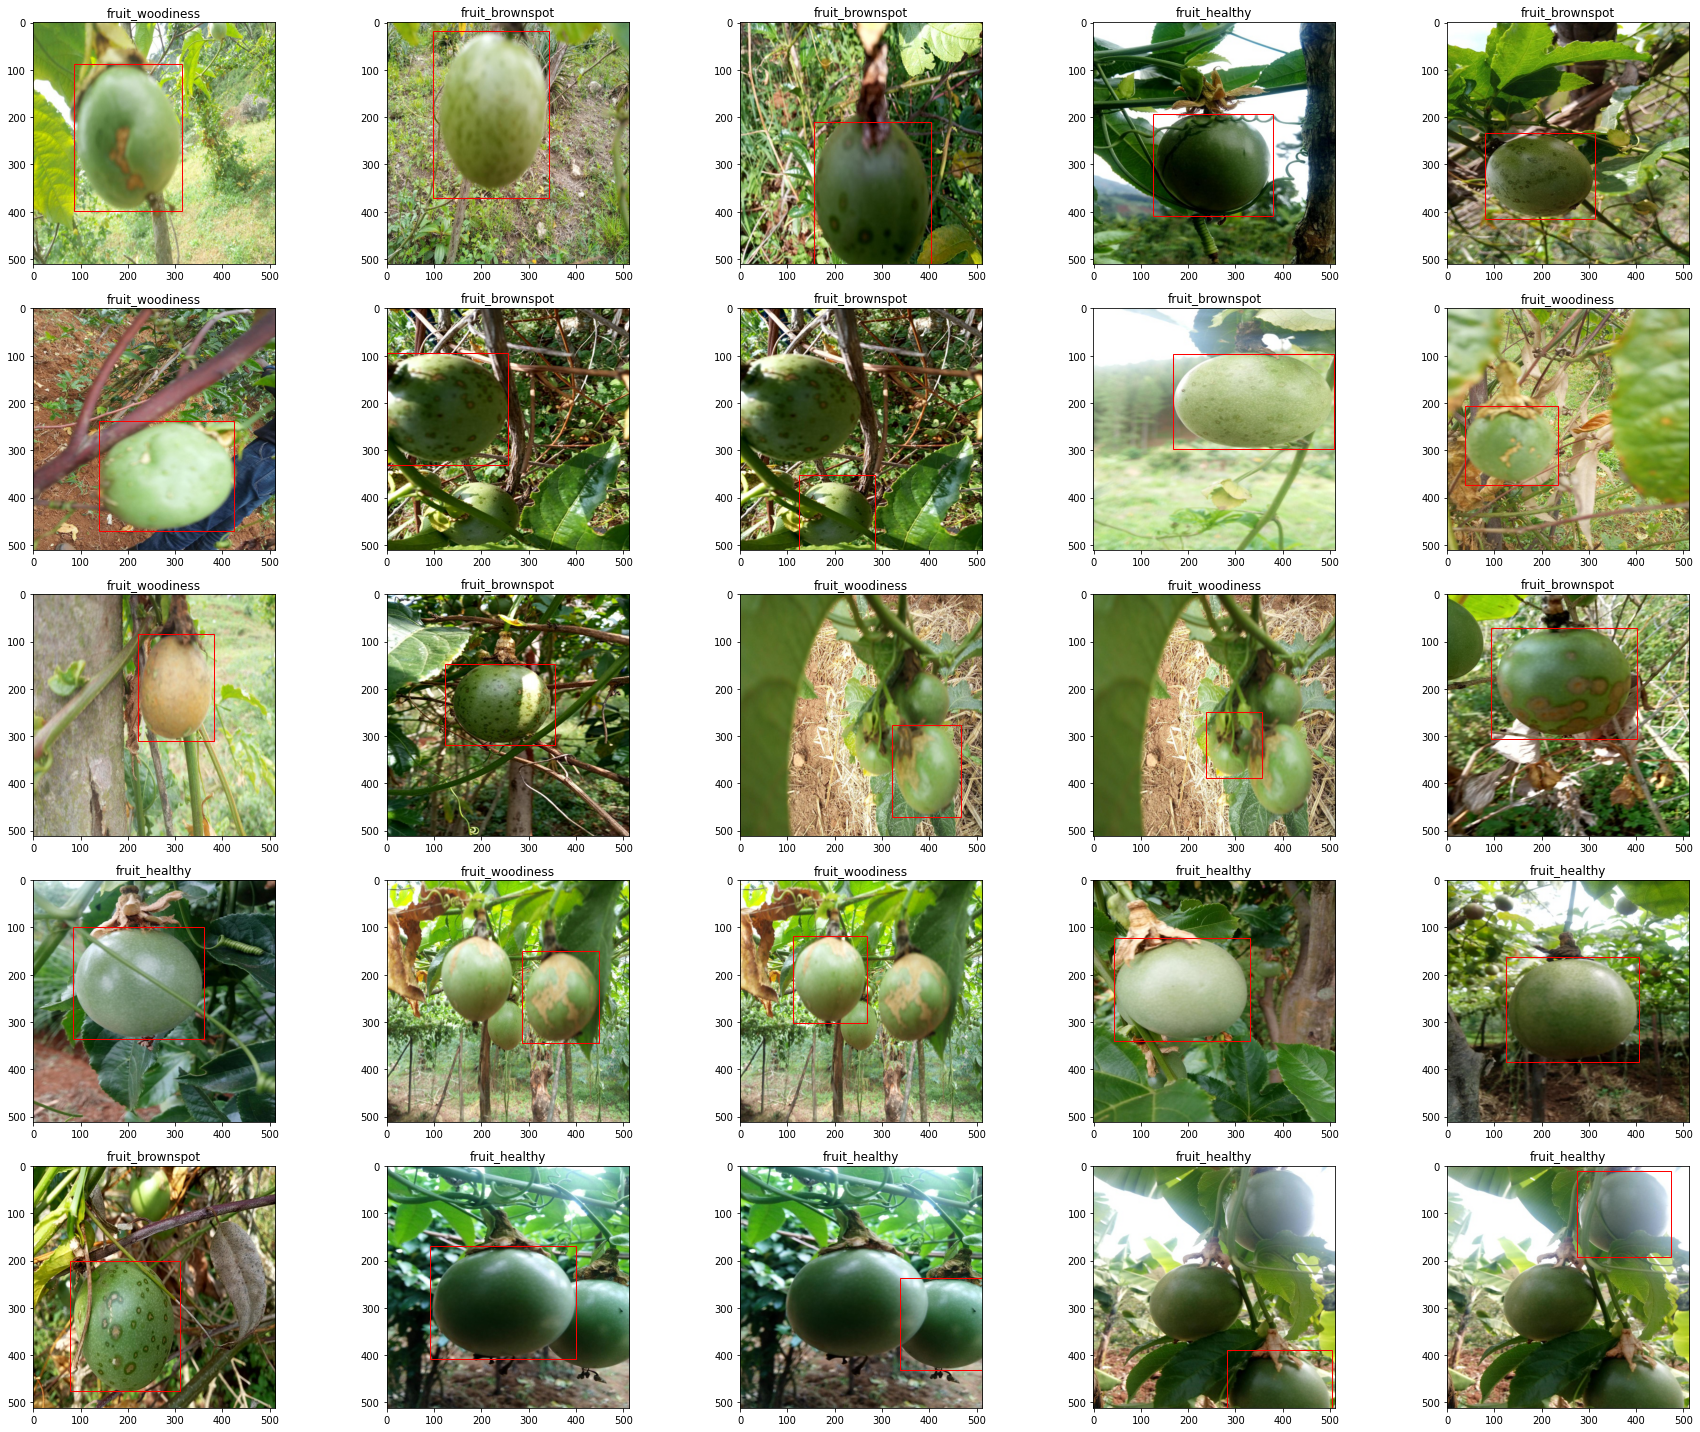

In [7]:
plot_sample_images(df_train)

In [8]:
df_train.head

<bound method NDFrame.head of          Image_ID            class   xmin   ymin  width  height
0     ID_007FAIEI  fruit_woodiness   87.0   87.5  228.0   311.0
1     ID_00G8K1V3  fruit_brownspot   97.5   17.5  245.0   354.5
2     ID_00WROUT9  fruit_brownspot  156.5  209.5  248.0   302.5
3     ID_00ZJEEK3    fruit_healthy  125.0  193.0  254.5   217.0
4     ID_018UIENR  fruit_brownspot   79.5  232.5  233.5   182.0
...           ...              ...    ...    ...    ...     ...
3901  ID_ZZAB1FH1    fruit_healthy   96.0  175.5  289.5   222.0
3902  ID_ZZAB1FH1    fruit_healthy  330.0  241.0  182.0   180.5
3903  ID_ZZJZ2CV6    fruit_healthy  358.0  234.0  134.5   107.0
3904  ID_ZZJZ2CV6    fruit_healthy   98.5  135.0  275.5   213.5
3905  ID_ZZO9KIH9  fruit_woodiness  123.5  218.5  197.5   153.5

[3906 rows x 6 columns]>

In [9]:
img.imread(f'{colabPath}/Train_Images/ID_007FAIEI.jpg').shape

(512, 512, 3)

# Looking at this tutorial: 

https://www.tensorflow.org/tutorials/images/classification

# From original example

In [10]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3012, done.
remote: Counting objects: 100% (3012/3012), done.
remote: Compressing objects: 100% (2540/2540), done.
remote: Total 3012 (delta 758), reused 1315 (delta 433), pack-reused 0
Receiving objects: 100% (3012/3012), 33.21 MiB | 40.24 MiB/s, done.
Resolving deltas: 100% (758/758), done.


In [11]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1675218 sha256=f3519cc10c64ef95533a41675b3a951c4baa698e998788cb7e05677a63ffe424
  Stored in directory: /tmp/pip-ephem-wheel-cache-lzov70ox/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=81cfa88a9b3ff5ae14c1e6475a2819bcd52fec0ac683baf33599ca87294b6519
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=3e4eb3e3637bc34f5942568d15697496f3b5db870f8a91aea2c383b0812cfd85
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78546 sha256=bc28310432d7975632f3570c9e5f1d234ee0d9e91fa2bed09

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [12]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [13]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=False, # This used to be true for the example
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)





In [14]:
def plot_detections_norm(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(30, 30),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True, # This used to be true for the example
      min_score_thresh=0.3)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

# Rubber Ducky data

We will start with some toy (literally) data consisting of 5 images of a rubber
ducky.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain rubber duckies (or even ducks for that matter), so this is a novel class.

In [15]:
# # Load images and visualize
# train_image_dir = 'models/research/object_detection/test_images/ducky/train/'
# train_images_np = []
# for i in range(1, 6):
#   image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
#   train_images_np.append(load_image_into_numpy_array(image_path))

# plt.rcParams['axes.grid'] = False
# plt.rcParams['xtick.labelsize'] = False
# plt.rcParams['ytick.labelsize'] = False
# plt.rcParams['xtick.top'] = False
# plt.rcParams['xtick.bottom'] = False
# plt.rcParams['ytick.left'] = False
# plt.rcParams['ytick.right'] = False
# plt.rcParams['figure.figsize'] = [14, 7]

# for idx, train_image_np in enumerate(train_images_np):
#   plt.subplot(2, 3, idx+1)
#   plt.imshow(train_image_np)
# plt.show()

In [16]:
# image_path = os.path.join(train_image_dir, 'robertducky' + '4'+ '.jpg')
# img.imread(image_path).shape 


# DNN PF Data:

In [17]:
len(df_train)

3906

# Convert boundaries into format for tf obj detection:

https://pandas.pydata.org/docs/getting_started/intro_tutorials/05_add_columns.html

In [18]:
  # ymin  width  heightxmin   ymin  width  height
df_gt = df_train
# https://stackoverflow.com/questions/13187778/convert-pandas-dataframe-to-numpy-array/
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html


In [19]:
df_gt['xmax'] = df_gt['xmin'] + df_gt['width']
df_gt['ymax'] = df_gt['ymin'] + df_gt['height']

In [20]:
df_gt.head()

Image_ID            class   xmin   ymin  width  height   xmax   ymax
0  ID_007FAIEI  fruit_woodiness   87.0   87.5  228.0   311.0  315.0  398.5
1  ID_00G8K1V3  fruit_brownspot   97.5   17.5  245.0   354.5  342.5  372.0
2  ID_00WROUT9  fruit_brownspot  156.5  209.5  248.0   302.5  404.5  512.0
3  ID_00ZJEEK3    fruit_healthy  125.0  193.0  254.5   217.0  379.5  410.0
4  ID_018UIENR  fruit_brownspot   79.5  232.5  233.5   182.0  313.0  414.5

In [21]:
df_gt_only = df_gt[['ymin','xmin','ymax','xmax']]
df_gt_only

ymin   xmin   ymax   xmax
0      87.5   87.0  398.5  315.0
1      17.5   97.5  372.0  342.5
2     209.5  156.5  512.0  404.5
3     193.0  125.0  410.0  379.5
4     232.5   79.5  414.5  313.0
...     ...    ...    ...    ...
3901  175.5   96.0  397.5  385.5
3902  241.0  330.0  421.5  512.0
3903  234.0  358.0  341.0  492.5
3904  135.0   98.5  348.5  374.0
3905  218.5  123.5  372.0  321.0

[3906 rows x 4 columns]

# Get examples per class:
https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

We have unnormalized coordinates, so I modifed to conform to this:

https://stackoverflow.com/questions/48915003/get-the-bounding-box-coordinates-in-the-tensorflow-object-detection-api-tutorial

## fruit_healthy

In [22]:
df_train_fruit_healthy = df_gt.loc[df_gt['class'] == 'fruit_healthy']
df_train_fruit_healthy

Image_ID          class   xmin   ymin  width  height   xmax   ymax
3     ID_00ZJEEK3  fruit_healthy  125.0  193.0  254.5   217.0  379.5  410.0
15    ID_05R05ZLJ  fruit_healthy   85.0   99.5  276.5   236.5  361.5  336.0
18    ID_06EXUMWA  fruit_healthy   43.5  122.0  287.0   217.5  330.5  339.5
19    ID_06GLI7SR  fruit_healthy  125.0  163.5  280.0   222.0  405.0  385.5
21    ID_06N0H7F1  fruit_healthy   91.0  168.5  309.5   239.0  400.5  407.5
...           ...            ...    ...    ...    ...     ...    ...    ...
3900  ID_ZZ5YBO5A  fruit_healthy  112.0  207.0  208.0   176.5  320.0  383.5
3901  ID_ZZAB1FH1  fruit_healthy   96.0  175.5  289.5   222.0  385.5  397.5
3902  ID_ZZAB1FH1  fruit_healthy  330.0  241.0  182.0   180.5  512.0  421.5
3903  ID_ZZJZ2CV6  fruit_healthy  358.0  234.0  134.5   107.0  492.5  341.0
3904  ID_ZZJZ2CV6  fruit_healthy   98.5  135.0  275.5   213.5  374.0  348.5

[1638 rows x 8 columns]

In [23]:
df_train_fruit_healthy_bb_only = df_train_fruit_healthy[['ymin','xmin','ymax','xmax']]/512
df_train_fruit_healthy_bb_only

ymin      xmin      ymax      xmax
3     0.376953  0.244141  0.800781  0.741211
15    0.194336  0.166016  0.656250  0.706055
18    0.238281  0.084961  0.663086  0.645508
19    0.319336  0.244141  0.752930  0.791016
21    0.329102  0.177734  0.795898  0.782227
...        ...       ...       ...       ...
3900  0.404297  0.218750  0.749023  0.625000
3901  0.342773  0.187500  0.776367  0.752930
3902  0.470703  0.644531  0.823242  1.000000
3903  0.457031  0.699219  0.666016  0.961914
3904  0.263672  0.192383  0.680664  0.730469

[1638 rows x 4 columns]

In [24]:
gt_box_list_pf = []
for i in range(len(df_train_fruit_healthy_bb_only)):
  gt_box_list_pf.append(df_train_fruit_healthy_bb_only.iloc[i].to_numpy(dtype=np.float32).reshape(1,-1))

gt_boxes_fruit_healthy = gt_box_list_pf

# We have unnormalized coordinates, so I modifed to conform to this:

# https://stackoverflow.com/questions/48915003/get-the-bounding-box-coordinates-in-the-tensorflow-object-detection-api-tutorial
# gt_boxes_fruit_healthy

In [25]:
train_images_fruit_healthy_np = []
    
for idx, row in df_train_fruit_healthy.iloc[:, :].iterrows():
    # image = img.imread(f'{img_folder}/{row["Image_ID"]}.jpg')
    image_path = (f'{colabPath}/Train_Images/{row["Image_ID"]}.jpg')
    train_images_fruit_healthy_np.append(load_image_into_numpy_array(image_path))


In [26]:
train_images_fruit_healthy_np = np.array(train_images_fruit_healthy_np)

In [27]:
np.save('/content/drive/MyDrive/JHU/DNN/FinalProject/train_images_fruit_healthy_np.npy', train_images_fruit_healthy_np)

## fruit_woodiness

In [28]:
df_train_fruit_woodiness = df_gt.loc[df_gt['class'] == 'fruit_woodiness']
df_train_fruit_woodiness

Image_ID            class   xmin   ymin  width  height   xmax   ymax
0     ID_007FAIEI  fruit_woodiness   87.0   87.5  228.0   311.0  315.0  398.5
5     ID_01QZDXVQ  fruit_woodiness  139.5  238.5  285.5   231.5  425.0  470.0
9     ID_052XYWUM  fruit_woodiness   37.5  206.0  197.5   168.0  235.0  374.0
10    ID_055U1LPM  fruit_woodiness  220.5   84.0  161.5   227.0  382.0  311.0
12    ID_05A7I1ZP  fruit_woodiness  321.0  275.5  145.5   194.5  466.5  470.0
...           ...              ...    ...    ...    ...     ...    ...    ...
3887  ID_ZUT4UN5I  fruit_woodiness  147.5  126.0  158.0   235.5  305.5  361.5
3888  ID_ZUT4UN5I  fruit_woodiness    0.0  346.0  240.0   166.0  240.0  512.0
3889  ID_ZUT4UN5I  fruit_woodiness    0.0  251.0   36.5    86.5   36.5  337.5
3891  ID_ZVQRTWWC  fruit_woodiness  214.0  159.0  154.5   207.0  368.5  366.0
3905  ID_ZZO9KIH9  fruit_woodiness  123.5  218.5  197.5   153.5  321.0  372.0

[1246 rows x 8 columns]

In [29]:
df_train_fruit_woodiness_bb_only = df_train_fruit_woodiness[['ymin','xmin','ymax','xmax']]/512
df_train_fruit_woodiness_bb_only

ymin      xmin      ymax      xmax
0     0.170898  0.169922  0.778320  0.615234
5     0.465820  0.272461  0.917969  0.830078
9     0.402344  0.073242  0.730469  0.458984
10    0.164062  0.430664  0.607422  0.746094
12    0.538086  0.626953  0.917969  0.911133
...        ...       ...       ...       ...
3887  0.246094  0.288086  0.706055  0.596680
3888  0.675781  0.000000  1.000000  0.468750
3889  0.490234  0.000000  0.659180  0.071289
3891  0.310547  0.417969  0.714844  0.719727
3905  0.426758  0.241211  0.726562  0.626953

[1246 rows x 4 columns]

In [30]:
gt_box_list_pf = []
for i in range(len(df_train_fruit_woodiness_bb_only)):
  gt_box_list_pf.append(df_train_fruit_woodiness_bb_only.iloc[i].to_numpy(dtype=np.float32).reshape(1,-1))

gt_boxes_fruit_woodiness = gt_box_list_pf

# We have unnormalized coordinates, so I modifed to conform to this:

# https://stackoverflow.com/questions/48915003/get-the-bounding-box-coordinates-in-the-tensorflow-object-detection-api-tutorial
# gt_boxes_fruit_woodiness

In [31]:
train_images_fruit_woodiness_np = []
    
for idx, row in df_train_fruit_woodiness.iloc[:, :].iterrows():
    # image = img.imread(f'{img_folder}/{row["Image_ID"]}.jpg')
    image_path = (f'{colabPath}/Train_Images/{row["Image_ID"]}.jpg')
    train_images_fruit_woodiness_np.append(load_image_into_numpy_array(image_path))


In [32]:
len(train_images_fruit_woodiness_np)

1246

In [33]:
train_images_fruit_woodiness_np = np.array(train_images_fruit_woodiness_np)
np.save('/content/drive/MyDrive/JHU/DNN/FinalProject/train_images_fruit_woodiness_np.npy', train_images_fruit_woodiness_np)

## fruit_brownspot

In [34]:
df_train_fruit_brownspot = df_gt.loc[df_gt['class'] == 'fruit_brownspot']
df_train_fruit_brownspot

Image_ID            class   xmin   ymin  width  height   xmax   ymax
1     ID_00G8K1V3  fruit_brownspot   97.5   17.5  245.0   354.5  342.5  372.0
2     ID_00WROUT9  fruit_brownspot  156.5  209.5  248.0   302.5  404.5  512.0
4     ID_018UIENR  fruit_brownspot   79.5  232.5  233.5   182.0  313.0  414.5
6     ID_02PX7GI8  fruit_brownspot    1.5   94.5  256.0   236.0  257.5  330.5
7     ID_02PX7GI8  fruit_brownspot  124.0  352.5  160.5   159.5  284.5  512.0
...           ...              ...    ...    ...    ...     ...    ...    ...
3879  ID_ZSC2A6LO  fruit_brownspot  142.0   92.0  285.5   245.5  427.5  337.5
3892  ID_ZVSXUJSP  fruit_brownspot   88.0   90.5  309.5   269.5  397.5  360.0
3893  ID_ZWF3T8FA  fruit_brownspot   97.5  133.5  257.0   198.5  354.5  332.0
3894  ID_ZWTUUTWM  fruit_brownspot  110.0  181.5  288.5   233.0  398.5  414.5
3899  ID_ZZ0MWI19  fruit_brownspot   90.5   18.5  327.0   267.0  417.5  285.5

[1022 rows x 8 columns]

In [35]:
df_train_fruit_brownspot_bb_only = df_train_fruit_brownspot[['ymin','xmin','ymax','xmax']]/512
df_train_fruit_brownspot_bb_only

ymin      xmin      ymax      xmax
1     0.034180  0.190430  0.726562  0.668945
2     0.409180  0.305664  1.000000  0.790039
4     0.454102  0.155273  0.809570  0.611328
6     0.184570  0.002930  0.645508  0.502930
7     0.688477  0.242188  1.000000  0.555664
...        ...       ...       ...       ...
3879  0.179688  0.277344  0.659180  0.834961
3892  0.176758  0.171875  0.703125  0.776367
3893  0.260742  0.190430  0.648438  0.692383
3894  0.354492  0.214844  0.809570  0.778320
3899  0.036133  0.176758  0.557617  0.815430

[1022 rows x 4 columns]

In [36]:
gt_box_list_pf = []
for i in range(len(df_train_fruit_brownspot_bb_only)):
  gt_box_list_pf.append(df_train_fruit_brownspot_bb_only.iloc[i].to_numpy(dtype=np.float32).reshape(1,-1))

gt_boxes_fruit_brownspot = gt_box_list_pf

# We have unnormalized coordinates, so I modifed to conform to this:

# https://stackoverflow.com/questions/48915003/get-the-bounding-box-coordinates-in-the-tensorflow-object-detection-api-tutorial
# gt_boxes_fruit_brownspot

In [37]:
train_images_fruit_brownspot_np = []
    
for idx, row in df_train_fruit_brownspot.iloc[:, :].iterrows():
    # image = img.imread(f'{img_folder}/{row["Image_ID"]}.jpg')
    image_path = (f'{colabPath}/Train_Images/{row["Image_ID"]}.jpg')
    train_images_fruit_brownspot_np.append(load_image_into_numpy_array(image_path))


In [38]:
train_images_fruit_brownspot_np = np.array(train_images_fruit_brownspot_np)
np.save('/content/drive/MyDrive/JHU/DNN/FinalProject/train_images_fruit_brownspot_np.npy', train_images_fruit_brownspot_np)

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [39]:

# # By convention, our non-background classes start counting at 1.  Given
# # that we will be predicting just one class, we will therefore assign it a
# # `class id` of 1.
# duck_class_id = 1
# num_classes = 1

# category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}




In [40]:
num_classes = 3
# https://towardsdatascience.com/using-tensorflow-lite-for-object-detection-2a0283f94aed
category_index = {1: {'id': 1, 'name': 'fruit_healthy'},
                2: {'id': 2, 'name': 'fruit_woodiness'},
                 3: {'id': 3, 'name': 'fruit_brownspot'}}
# num_classes = 1
# category_index = {1: {'id': 1, 'name': 'fruit_healthy'}}

In [41]:
category_index

{1: {'id': 1, 'name': 'fruit_healthy'},
 2: {'id': 2, 'name': 'fruit_woodiness'},
 3: {'id': 3, 'name': 'fruit_brownspot'}}

In [42]:
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

# Add fruit_healthy
for (train_image_np, gt_box_np) in zip(
    train_images_fruit_healthy_np, gt_boxes_fruit_healthy):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  # zero_indexed_groundtruth_classes = tf.convert_to_tensor(
  #     np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
       np.array([0]), num_classes))

# Add fruit_woodiness
for (train_image_np, gt_box_np) in zip(
    train_images_fruit_woodiness_np, gt_boxes_fruit_woodiness):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  # zero_indexed_groundtruth_classes = tf.convert_to_tensor(
  #     np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
     np.array([1]), num_classes))

# Add fruit_brownspot
for (train_image_np, gt_box_np) in zip(
    train_images_fruit_brownspot_np, gt_boxes_fruit_brownspot):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  # zero_indexed_groundtruth_classes = tf.convert_to_tensor(
  #     np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
     np.array([2]), num_classes))
print('Done prepping data.')


Done prepping data.


In [43]:
train_image_tensors[0].shape

TensorShape([1, 512, 512, 3])

In [44]:
gt_classes_one_hot_tensors[2].shape

TensorShape([1, 3])

In [45]:
gt_box_tensors[0].shape

TensorShape([1, 4])

# Let's just visualize as a sanity check


In [46]:
gt_boxes_fruit_brownspot[0]

array([[0.03417969, 0.19042969, 0.7265625 , 0.6689453 ]], dtype=float32)

In [47]:
 np.array([3])

array([3])

In [48]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%
dummy_scores

array([1.], dtype=float32)

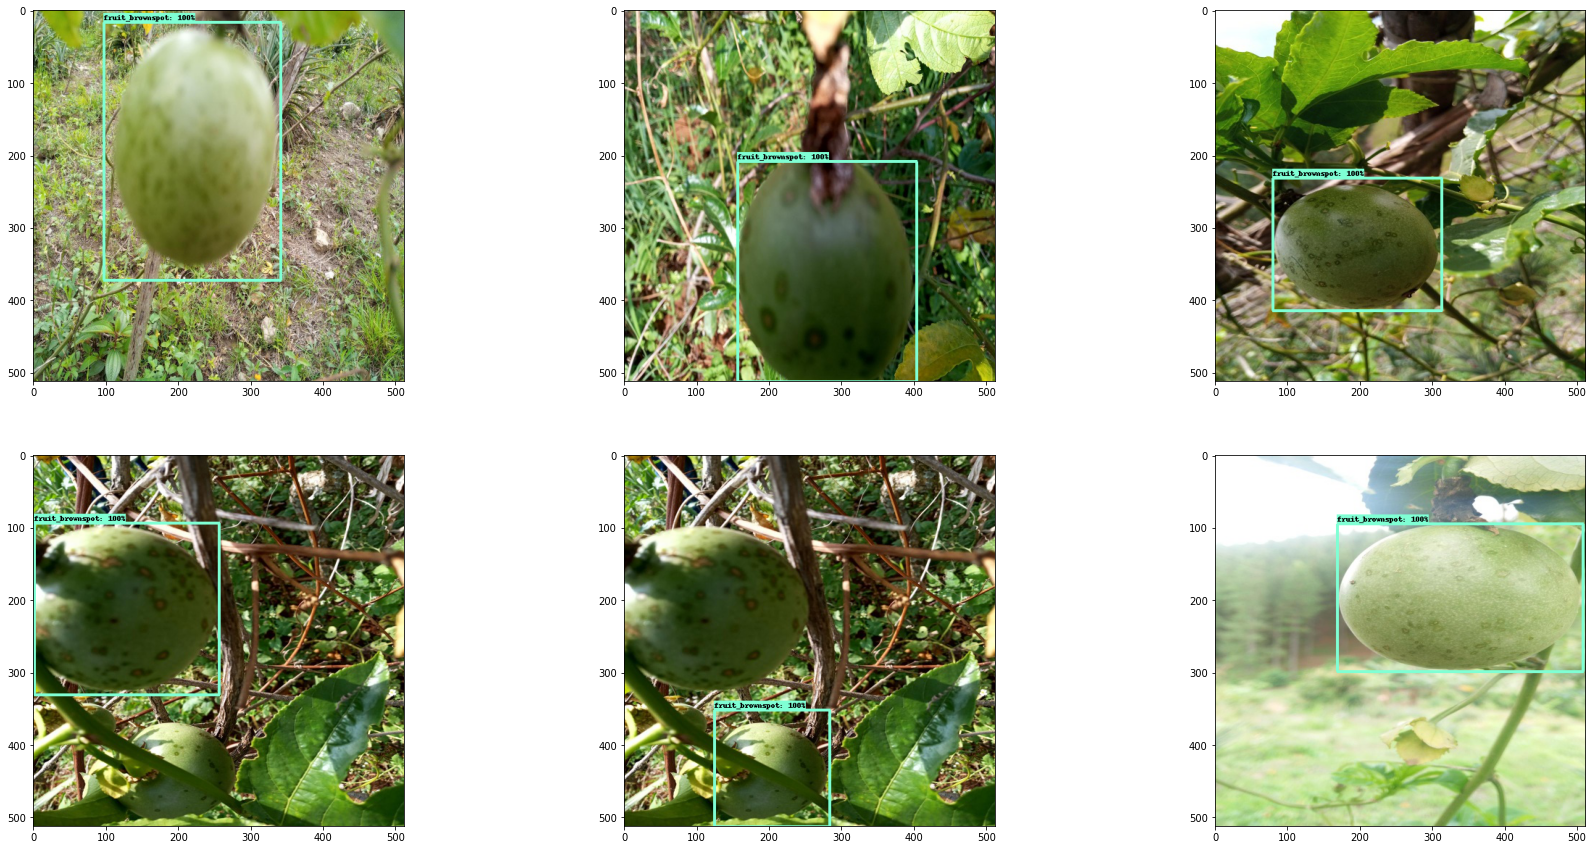

In [49]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections_norm(
      train_images_fruit_brownspot_np[idx],
      gt_boxes_fruit_brownspot[idx],
      np.array([3]),
      # np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

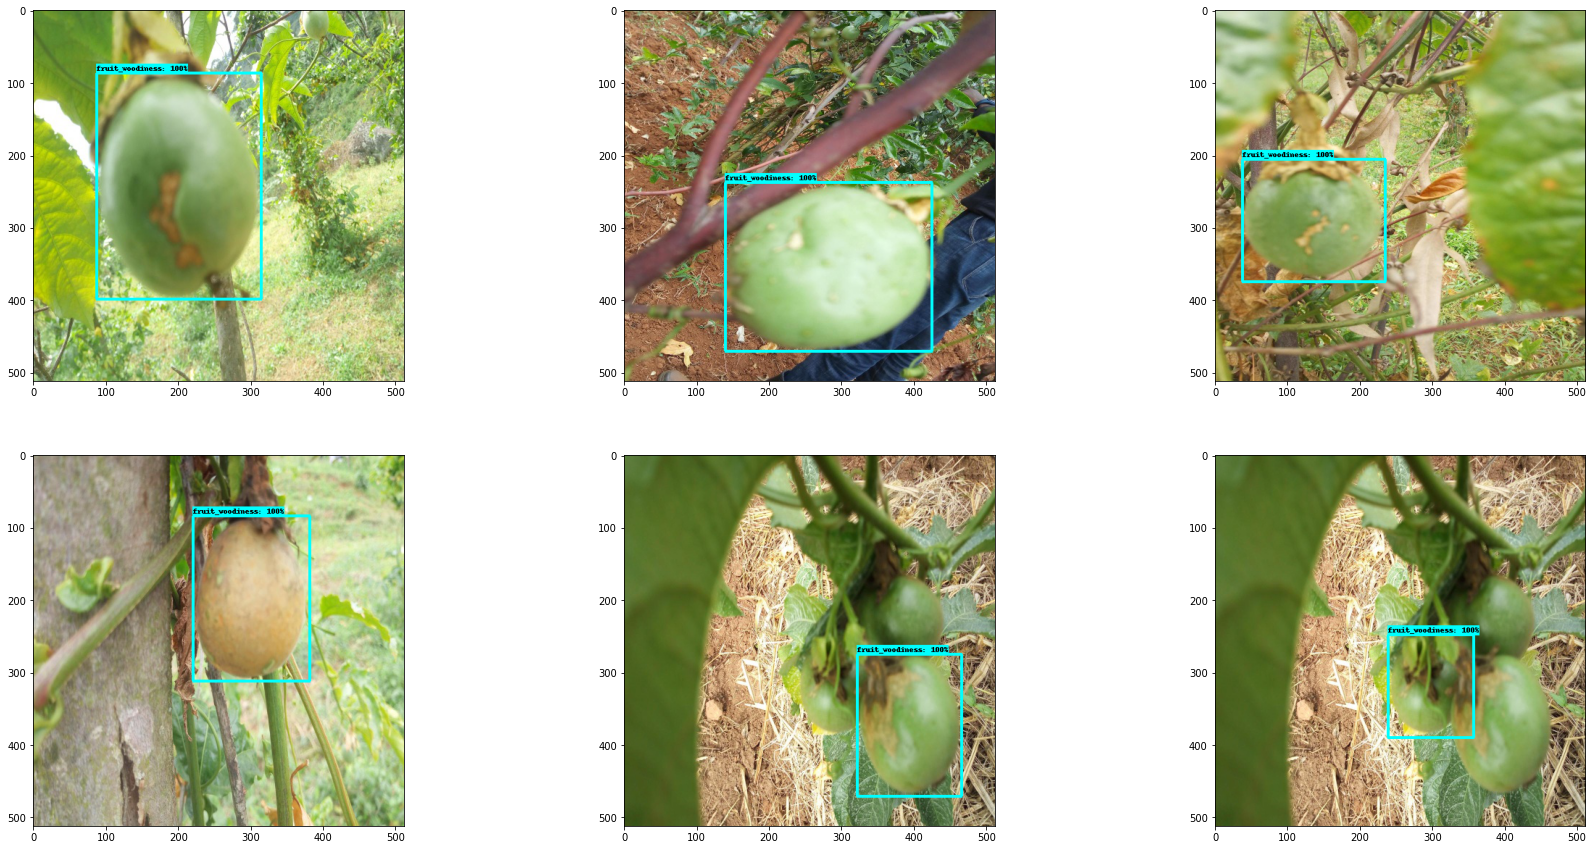

In [50]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections_norm(
      train_images_fruit_woodiness_np[idx],
      gt_boxes_fruit_woodiness[idx],
      np.array([2]),
      # np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

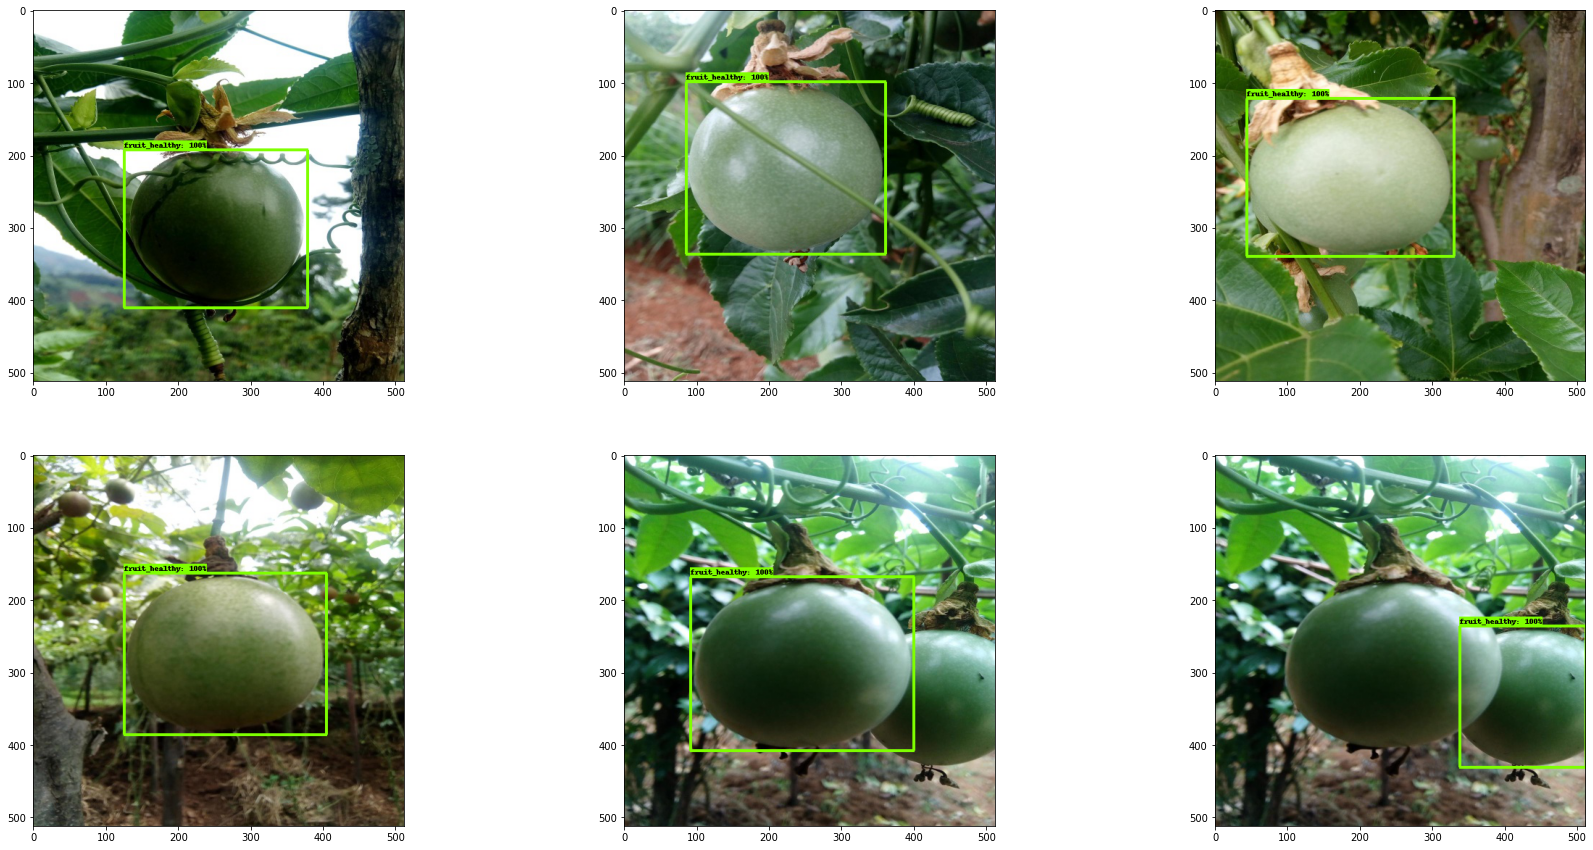

In [51]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections_norm(
      train_images_fruit_healthy_np[idx],
      gt_boxes_fruit_healthy[idx],
      np.array([1]),
      # np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/

Download models from https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [52]:
# # Download the checkpoint and put it into models/research/object_detection/test_data/

# !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# !tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# !mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [53]:
# # Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
!tar -xf efficientdet_d0_coco17_tpu-32.tar.gz
!mv efficientdet_d0_coco17_tpu-32/checkpoint models/research/object_detection/test_data/


--2021-10-19 14:35:18--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.111.128, 2607:f8b0:4001:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.111.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M   100MB/s    in 0.3s    

2021-10-19 14:35:18 (100 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]



In [54]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 3

pipeline_config = 'models/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



In [55]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
# batch_size = 4
# batch_size = len(df_train) TOO MUCH RAM
batch_size = 65
learning_rate = 0.05
num_batches = 1000

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[512, 512, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  # all_keys = list(range(len(train_images_np)))
  all_keys = list(range(len(train_image_tensors)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.7/dist-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 1000, loss=1.7607062
batch 10 of 1000, loss=1.6622248
batch 20 of 1000, loss=1.5246035
batch 30 of 1000, loss=1.3512079
batch 40 of 1000, loss=1.2136427
batch 50 of 1000, loss=1.1479025
batch 60 of 1000, loss=1.1242957
batch 70 of 1000, loss=1.1440505
batch 80 of 1000, loss=1.065182
batch 90 of 1000, loss=1.0714992
batch 100 of 1000, loss=1.0375216
batch 110 of 1000, loss=1.0188322
batch 120 of 1000, loss=1.0724115
batch 130 of 1000, loss=1.0212443
batch 140 of 1000, loss=0.9938356
batch 150 of 1000, loss=1.0491832
batch 160 of 1000, loss=1.0019588
batch 170 of 1000, loss=0.9582392
batch 180 of 1000, loss=1.018685
batch 190 of 1000, loss=0.98455524
batch 200 of 1000, loss=0.99478555
batch 210 of 1000, loss=0.9981519
batch 220 of 1000, loss=1.0181936
batch 230 of 1000, loss=0.9325485
batch 240 of 1000, loss=1.0292808
batch 250 of 1000, loss=0.97435284
batch 260 of 1000, loss=0.9463084
batch 270 of 1000, loss=0.97221684
batch 280 of 1000, loss=0.983276
batch 290 of 1000, loss=

# Load test images and run inference with new model!



In [56]:
test_image_dir = f'{colabPath}/Test_Images/'
test_images_np = []

for idx, row in df_test.iloc[:, :].iterrows():
  image_path = (f'{colabPath}/Test_Images/{row["Image_ID"]}.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)



NOTE THAT Inferences are in batches: https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/plot_object_detection_checkpoint.html?highlight=batches

THUS, RETURN the highest couple (in the  current baseline just did argmax  (so highest one))

```
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
```

In [57]:
# detections = detect(tf.convert_to_tensor(test_images_np[0], dtype=tf.float32))
# print(detections)
# print('detection_boxes',detections['detection_boxes'][0].numpy())
# print('detection_classes',detections['detection_classes'][0].numpy().astype(np.uint32)
#       + label_id_offset)
# print('detection_scores',detections['detection_scores'][0].numpy())

In [58]:
    detections = detect(tf.convert_to_tensor(test_images_np[0], dtype=tf.float32))

    # # All outputs are batches tensors.
    # # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # # We're only interested in the first num_detections.
    # num_detections = int(detections.pop('num_detections'))
    # detections = {key: value[0, :num_detections].numpy()
    #               for key, value in detections.items()}
    # detections['num_detections'] = num_detections

    # # detection_classes should be ints.
    # detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

In [59]:
detections.keys()

dict_keys(['detection_boxes', 'detection_scores', 'detection_classes', 'num_detections', 'raw_detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices'])

In [60]:
detections['detection_boxes'][0].numpy()[0].reshape(1,4)

array([[0.30248016, 0.1774295 , 0.7564369 , 0.72752774]], dtype=float32)

In [61]:
detections['detection_classes'][0]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0., 2., 1., 0., 2., 1., 1., 1., 2., 1., 1., 2., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 2., 2., 1., 2., 0., 2., 1., 1., 0., 2., 0., 0.,
       1., 2., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 1., 1., 0., 1., 0.,
       1., 2., 2., 1., 0., 0., 1., 0., 0., 2., 2., 2., 2., 0., 0., 0., 0.,
       1., 1., 2., 1., 1., 0., 1., 1., 1., 2., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 1., 2., 0., 1., 0., 0., 1., 1., 2., 1., 0., 2.],
      dtype=float32)>

In [62]:
 np.atleast_1d(detections['detection_classes'][0].numpy().astype(np.uint32)[0])

array([0], dtype=uint32)

In [63]:
np.atleast_1d(detections['detection_scores'][0].numpy()[0])

array([0.40061367], dtype=float32)

In [64]:
np.atleast_1d(detections['detection_scores']).shape

(1, 100)

In [65]:
np.atleast_1d(detections['detection_scores'][0])

array([0.40061367, 0.30799848, 0.23025134, 0.18796298, 0.12747452,
       0.12678161, 0.12370926, 0.12320766, 0.12078604, 0.11745495,
       0.11368403, 0.11258113, 0.11230698, 0.10705319, 0.106693  ,
       0.1058372 , 0.10544649, 0.1031751 , 0.10297048, 0.10217491,
       0.1006051 , 0.09906977, 0.09734258, 0.09071139, 0.08911127,
       0.08571684, 0.08458164, 0.0840036 , 0.08383614, 0.0834634 ,
       0.08242416, 0.08129436, 0.07935551, 0.07860634, 0.07841897,
       0.07715911, 0.07659912, 0.07586154, 0.07576063, 0.07354012,
       0.07307371, 0.07245588, 0.07140997, 0.06857818, 0.06794617,
       0.06742984, 0.06713277, 0.06677642, 0.06651515, 0.06645036,
       0.06628847, 0.06602797, 0.06521347, 0.06401405, 0.06236291,
       0.06236246, 0.06191504, 0.06129971, 0.06082219, 0.06068012,
       0.0605832 , 0.06043896, 0.05938178, 0.0579592 , 0.05758253,
       0.05726281, 0.05686659, 0.05386853, 0.05374441, 0.05276531,
       0.05258545, 0.05234298, 0.05027071, 0.0500339 , 0.04973

In [66]:
np.argmax(np.atleast_1d(detections['detection_scores'][0]))

0

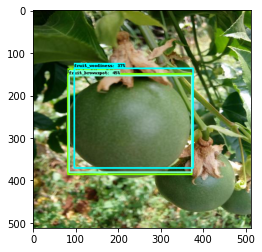

In [67]:
input_tensor = tf.convert_to_tensor(test_images_np[0], dtype=tf.float32)
detections = detect(input_tensor)

plot_detections_norm(
    test_images_np[0][0],
    detections['detection_boxes'][0].numpy(),
    detections['detection_classes'][0].numpy().astype(np.uint32)
    + label_id_offset,
    detections['detection_scores'][0].numpy(),
    category_index)

In [68]:
len(test_images_np)

931

In [69]:
# Create empty df:
# https://www.geeksforgeeks.org/how-to-create-an-empty-dataframe-and-append-rows-columns-to-it-in-pandas/

df_write = pd.DataFrame(columns = ['Image_ID', 'class', 'confidence', 'ymin','xmin','ymax','xmax'])
df_write

Empty DataFrame
Columns: [Image_ID, class, confidence, ymin, xmin, ymax, xmax]
Index: []

In [70]:
# create pd then write to csv
# for i in range(1):
for i in range(len(test_images_np)):

  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  imageID = df_test["Image_ID"][i]

  best_score_index = np.argmax(np.atleast_1d(detections['detection_scores'][0]))

  detection_class = np.atleast_1d(detections['detection_classes'][0].numpy().astype(np.uint32)[best_score_index])  + label_id_offset
  classVal = category_index[detection_class[0]]['name']

  detection_score = np.atleast_1d(detections['detection_scores'][0].numpy()[best_score_index])
  confidenceVal = detection_score[0]

  detection_box = detections['detection_boxes'][0].numpy()[best_score_index].reshape(1,4)[0]
  yminVal = detection_box[0]
  xminVal = detection_box[1]
  ymaxVal = detection_box[2]
  xmaxVal = detection_box[3]



  df_write = df_write.append({'Image_ID' : imageID, 'class':classVal , 'confidence':confidenceVal, 'ymin':yminVal,'xmin':xminVal,'ymax':ymaxVal,'xmax':xmaxVal},ignore_index=True)


In [71]:
df_write

Image_ID            class  confidence  ...      xmin      ymax      xmax
0    ID_IUJJG62B    fruit_healthy    0.400614  ...  0.177429  0.756437  0.727528
1    ID_ZPNDRD4T    fruit_healthy    0.521839  ...  0.229703  0.735227  0.596017
2    ID_AHFYB64P    fruit_healthy    0.270020  ...  0.002445  0.969192  0.755862
3    ID_L8JZLNTF  fruit_woodiness    0.307246  ...  0.304715  0.856946  0.664529
4    ID_IFMUXGPL  fruit_brownspot    0.238460  ...  0.315514  0.678841  0.780952
..           ...              ...         ...  ...       ...       ...       ...
926  ID_77MDJGMZ  fruit_woodiness    0.185285  ...  0.354619  0.966474  0.548491
927  ID_PG3E6NQT    fruit_healthy    0.495214  ...  0.222316  0.767143  0.785636
928  ID_038S0ONN    fruit_healthy    0.363239  ...  0.367699  0.678263  0.646320
929  ID_D5YBIDDT    fruit_healthy    0.299269  ...  0.329906  0.767483  0.853916
930  ID_2XGXT7SJ  fruit_brownspot    0.284961  ...  0.220752  0.797387  0.873217

[931 rows x 7 columns]

In [72]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
# https://stackoverflow.com/questions/16923281/writing-a-pandas-dataframe-to-csv-file
df_write.to_csv('/content/drive/MyDrive/JHU/DNN/FinalProject/submission.csv', encoding='utf-8', index=False)


In [73]:
df_write['ymin'] = df_write['ymin']*512

In [74]:
df_write['xmin'] = df_write['xmin']*512
df_write['ymax'] = df_write['ymax']*512
df_write['xmax'] = df_write['xmax']*512

In [75]:
df_write

Image_ID            class  ...        ymax        xmax
0    ID_IUJJG62B    fruit_healthy  ...  387.295685  372.494202
1    ID_ZPNDRD4T    fruit_healthy  ...  376.436066  305.160767
2    ID_AHFYB64P    fruit_healthy  ...  496.226257  387.001282
3    ID_L8JZLNTF  fruit_woodiness  ...  438.756561  340.238831
4    ID_IFMUXGPL  fruit_brownspot  ...  347.566742  399.847412
..           ...              ...  ...         ...         ...
926  ID_77MDJGMZ  fruit_woodiness  ...  494.834717  280.827637
927  ID_PG3E6NQT    fruit_healthy  ...  392.777374  402.245544
928  ID_038S0ONN    fruit_healthy  ...  347.270813  330.915710
929  ID_D5YBIDDT    fruit_healthy  ...  392.951080  437.204773
930  ID_2XGXT7SJ  fruit_brownspot  ...  408.261902  447.086884

[931 rows x 7 columns]

In [76]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
# https://stackoverflow.com/questions/16923281/writing-a-pandas-dataframe-to-csv-file
df_write.to_csv('/content/drive/MyDrive/JHU/DNN/FinalProject/submission_unnormalized.csv', encoding='utf-8', index=False)

In [77]:
# # Note that the first frame will trigger tracing of the tf.function, which will
# # take some time, after which inference should be fast.

# label_id_offset = 1


# plt.figure(figsize=(30, 15))

# for i in range(len(test_images_np)):
#   plt.subplot(5, 2, i+1)
#   input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
#   detections = detect(input_tensor)

#   batch_index = 10

#   plot_detections(
#       test_images_np[i][0],
#       detections['detection_boxes'][0].numpy()[batch_index].reshape(1,4),
#       np.atleast_1d(detections['detection_classes'][0].numpy().astype(np.uint32)[batch_index])
#       + label_id_offset,
#       np.atleast_1d(detections['detection_scores'][0].numpy()[batch_index]),
#       category_index)
# plt.show()

* 512? 
* Write to csv?